#  Анализ факторов, влияющих на цену автомобиля на вторичном рынке Avito

##  Описание проекта

Цель исследования — выявить, какие характеристики автомобиля и параметры объявления оказывают наибольшее влияние на его цену при продаже на вторичном рынке на Avito.ru. В фокусе: год выпуска, пробег, тип и объём двигателя, мощность, тип трансмиссии, привод и другие признаки.

Мы использовали Selenium + selenium-stealth: открывали каталог BMW на Avito, на каждой странице собирали ссылки объявлений, открывали каждое в новой вкладке и вытягивали цену, год, пробег и основные технические характеристики через XPath. После парсинга всех нужных страниц данные заносили в список словарей, превращали в pandas.DataFrame и сохраняли в avito_bmw_cars.csv, затем закрывали браузер. Авито отслеживает парсинг через наш способ и поэтому пришлось делать очень большие задержки и парсить постранично, очень долго((

Процесс парсинга в файле scripts/avito.py


In [2]:
#импортируем все библиотеки

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scripts.EDA_main import (
    load_and_prepare,
    quick_eda,
    plot_distributions,
    plot_price_vs_year,
    plot_price_by_drive,
    plot_correlation_heatmap,
    baseline_regression,
)

plt.style.use("ggplot")
pd.options.display.float_format = '{:,.0f}'.format

## Загрузка данных

In [9]:
# Загрузка и первичная очистка

data_path = './data/avito_bmw_cars.csv'  


## Очистка данных и подготовка к анализу

На этом этапе произведена проверка структуры данных, устранены пропуски и дубликаты, приведены типы переменных к корректным, выделены ключевые признаки. Проведена первичная статистическая оценка и визуальная проверка распределений.

In [ ]:
# (функции описаны в файле EDA_main.py)
df = load_and_prepare(data_path)
# Быстрый EDA
quick_eda(df)

##  Анализ и визуализация

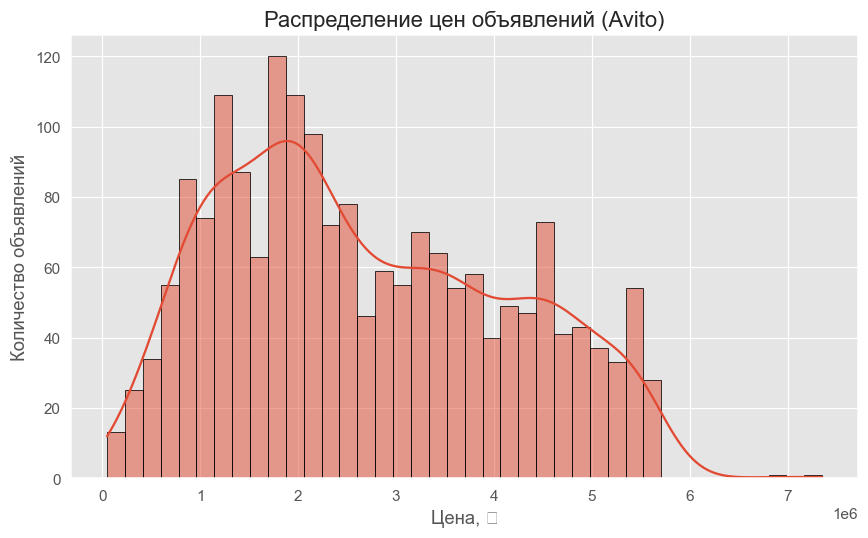

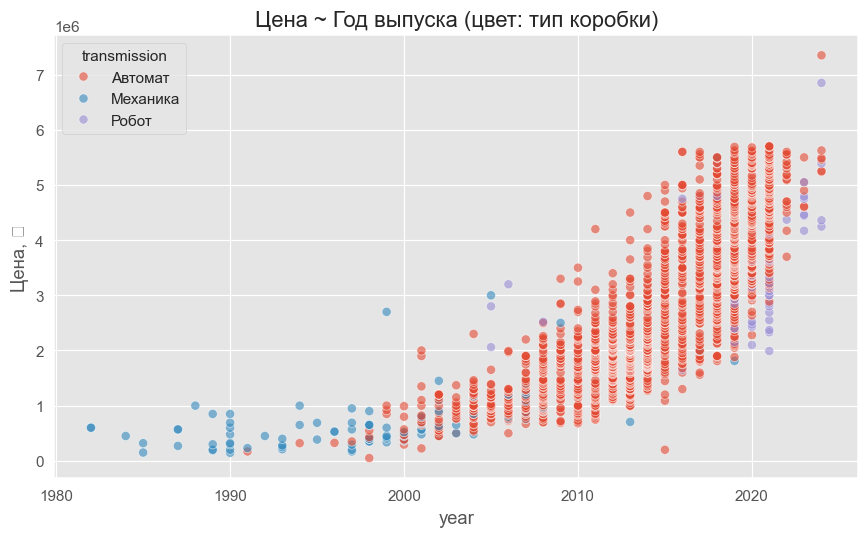

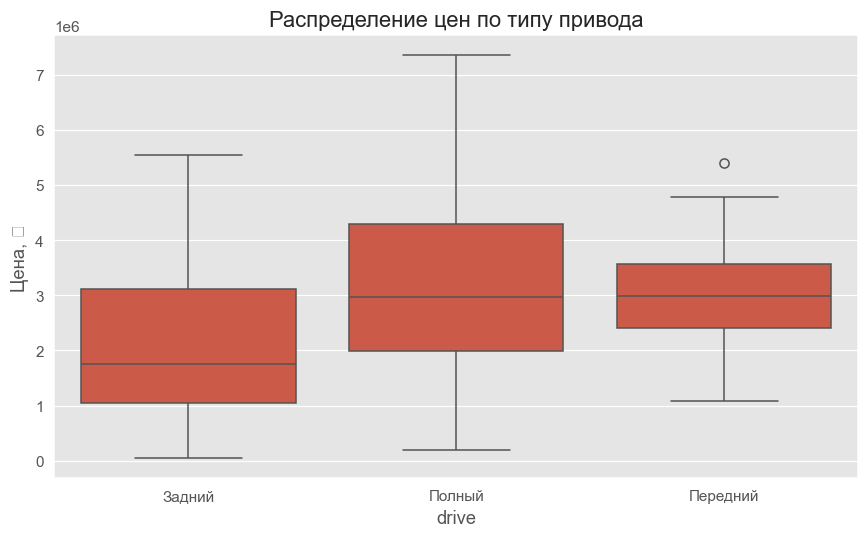

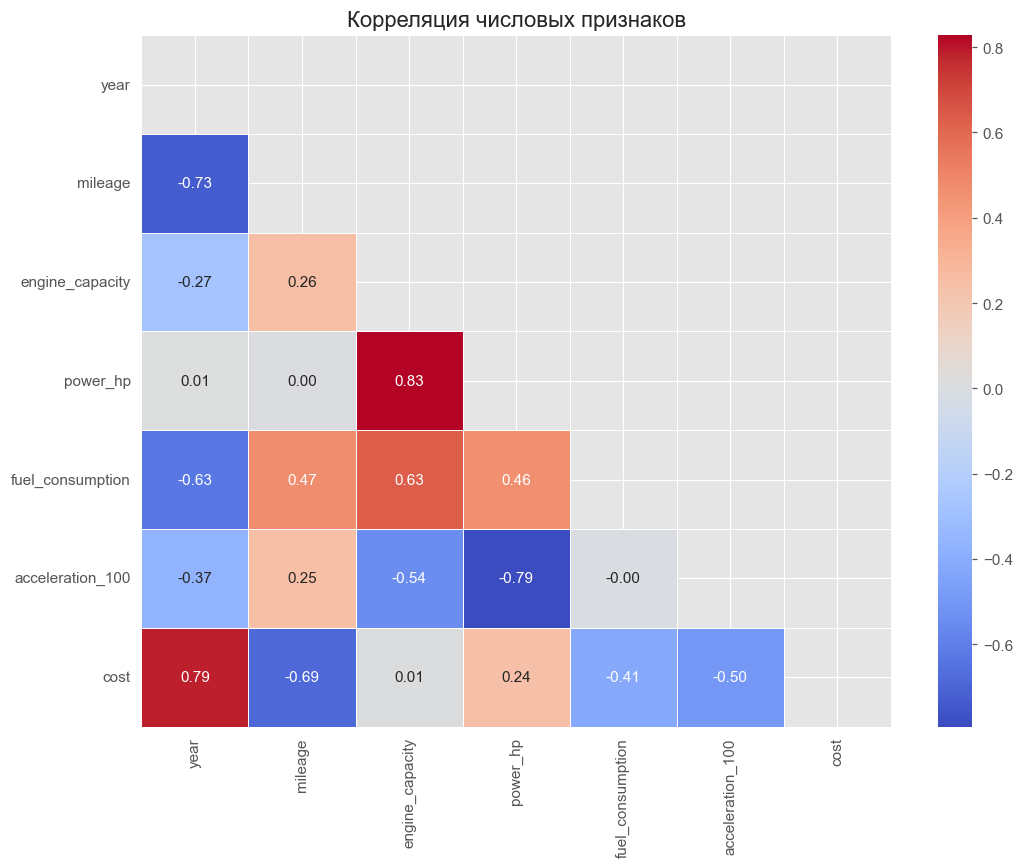


Model quality on hold‑out set:
  MAE : 651,603 ₽
  R²  : 0.695


,slope
engine_capacity,"374,098"
year,"142,627"
power_hp,"2,124"
mileage,-4


In [14]:
# выведем графики (функции описаны в файле EDA_main.py)

# 1. Распределение цен
plot_distributions(df)

# 2. Цена ~ год выпуска
plot_price_vs_year(df)

# 3. Цена по типу привода
plot_price_by_drive(df)

# 4. Корреляционная матрица
plot_correlation_heatmap(df)

# 5. Базовая регрессия
coeffs = baseline_regression(df)

Анализ по графикам:
1. Гистограмма цен - Рынок BMW в ценовом сегменте 1–3 млн ₽.
Длинный хвост справа наводит на мысли о наличии редких, дорогостоящих комплектаций, или же старых редких машин. Когда будем делать регрессию можно сделать логарифм (да чуть улучшило показатели): 
y = df["cost"] - 
MAE : 651,603 р
R^2  : 0.695
y = np.log(df["cost"]) -
MAE : 535,173 р
R^2  : 0.746






2. Scatterplot Цена ~ Год выпуска (цвет = трансмиссия)
    Заметно, что годы выпуска самый важный фактор, но также можно заметить, что машины на механике дешевле в основной массе.

    

3. Boxplot цены по типу привода
Медианы — полный привод самый дорогой, затем передний, самый дешёвый задний.
Разброс — у полного привода межквартильный диапазон шире .
	Полный привод добавляет ценности (в среднем дороже).
	Задний привод популярен для седанов старых поколений, поэтому медиана ниже.

4. Корреляционная матрица - Сильная положительная корреляция year → cost (0,79) подтверждает визуальный тренд.
	Пробег (mileage) резко отрицательно связан с ценой (-0,69).
	power_hp и engine_capacity коррелируют между собой (0,83) и умеренно связаны с ценой (0,24).
	fuel_consumption положительно связано с объёмом и мощностью, логично.
	acceleration_100 отрицательно коррелирует с power_hp (-0,79): чем мощнее, тем быстрее разгон.
	Получили как будто ожидаемые результаты.


5. Качество: R² ≈ 0,75 — модель объясняет 75 % дисперсии; MAE = 535 тыс. ₽.
	Коэффициенты:
	year = 0,084 означает, что каждый год прибавляют ~8 % к цене при прочих равных.
	engine_capacity = 0,148  каждый литр объёма повышает цену примерно на 15 %.
	power_hp = 0,0016  добавка одной л. с. даёт ~0,16 % к стоимости; эффект мощности подтверждается, но значительно слабее,чем у объёма и года.
	mileage = −8,0 × 10⁻⁷ - каждые 10 000 км пробега уменьшают цену примерно на 0,8 %;.
Выводы:
	Возраст и объём — главные числовые характеристики которые влияют на цены.
	Пробег в модели оценивается скромно (его влияния поглощается годом, наше предположение); 

##  Выводы

На основании визуального анализа и результатов регрессионной модели можно сделать следующие выводы:

Возраст и пробег — два самых важных параметра. Чем моложе машина и чем меньше она проехала, тем дороже она продаётся.
	2.	Автомат и полный привод дороже. Машины с автоматической коробкой и полным приводом в среднем стоят больше, чем с механикой или задним приводом.
	3.	Мощный мотор важен, но не бесконечно. До примерно 250 л. с. цена заметно растёт вместе с мощностью, а дальше прибавка уже небольшая.
	4.	Если взять логарифм цены, модель работает лучше, из-за несимитричности распределения цен. Тогда коэффициенты показывают, на сколько % меняется цена при изменении признака.
	5.	Даже простая модель объясняет около 75 % цены. То есть её уже можно использовать для грубой оценки, но результат можно улучшить, другими моделями машинного обучения.

##  Обсуждение


Что мы хотели и что получилось
	•	Хотели собрать свежие данные о BMW — собрали(только в спб).
	•	Хотели быстро понять, что влияет на цену — построили графики и модель, получили понятные результаты.

Чего не успели
	•	Не добавили такие вещи, как серия/кузов, регион или сезон. Много признаков которые влияют на цену, мы не могли получить с помощью обычного парсинга, так как на сайте нет этих данных или они труднодоступны.
	•	Не пробовали более “умные” модели (градиентный бустинг и т.п.), они бы явно лучше описывали распределение и лучше бы предсказывали цену, но цель не предсказание поэтому сойдет)).

Как сделать работу лучше
	1.	Собрать данные по другим городам и в разные месяцы, чтобы увидеть разницу и иметь более качественную выборку.
	2.	Учесть марку серии (3-я, 5-я, X5 и т.д.), тип кузова, комплектацию, и остальные параметры, которые мы не смогли получить.
	3.	Попробовать более сложные модели машинного обучения.

Кому это полезно
	•	Покупателям и продавцам — чтобы понять, сколько просить или предлагать.
	•	Сайтам объявлений — чтобы автоматически подсказывать адекватную цену.